# Kaggle - Trending Products Weekly

- References:
    - https://www.kaggle.com/code/byfone/h-m-trending-products-weekly
    - https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook
    - https://www.kaggle.com/code/byfone/h-m-purchases-in-a-row/notebook




In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


tqdm.pandas()


In [19]:
sample_folder = './h-and-m-personalized-fashion-recommendations/sampled_data/'
df = pd.read_csv(os.path.join(sample_folder, 'train_0.csv'))
valid_sample = pd.read_csv(os.path.join(sample_folder, 'valid_0.csv'))

folder = './h-and-m-personalized-fashion-recommendations/'
le_articles = load(os.path.join(folder, 'le_articles.joblib'))
le_customers = load(os.path.join(folder, 'le_customers.joblib'))



In [20]:
df['customer_id'] = le_customers.transform(df['customer_id'])
df['article_id'] = le_articles.transform(df['article_id'])

df['article_id'] = df['article_id'].astype(np.int32)
df['customer_id'] = df['customer_id'].astype(np.int32)
df['sales_channel_id'] = df['sales_channel_id'].astype('int8')
df['price'] = df['price'].astype('float32')

df['t_dat'] = pd.to_datetime(df['t_dat'])

In [23]:
gb = df.groupby(['customer_id', 'article_id'])['t_dat'].nunique()
inx = gb[gb>1].index

df = df.set_index(['customer_id', 'article_id'])
df = df.loc[inx].copy().sort_index()

df['shift_dat'] = df.groupby(level=[0,1])['t_dat'].shift(1)
df['dist'] = (df['t_dat'] - df['shift_dat']).dt.days
dist = df.loc[df['dist'].notna(), 'dist'].values
vc = df['dist'].value_counts()
vc = vc[1:]

/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_29792/917143793.py:2: RuntimeWarning: overflow encountered in exp
  return a / np.sqrt(x) + b * np.exp(-c*x) + d


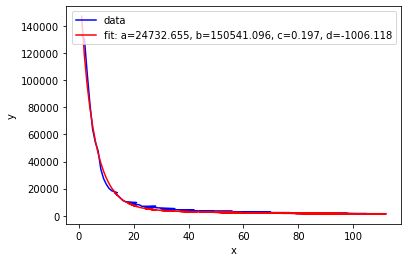

In [25]:
def func(x, a, b, c, d):
    return a / np.sqrt(x) + b * np.exp(-c*x) + d
# vc.index : 재구매 일수
# vc.values : 재구매 일수 별 횟수
popt, pcov = curve_fit(func, vc.index, vc.values)

plt.plot(vc.index[:100], vc.values[:100], 'b-', label='data')
plt.plot(vc.index[:100], func(vc.index[:100], *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [26]:
df = df.reset_index()


In [27]:
N = 12

last_ts = df['t_dat'].max()

tmp = df[['t_dat']].copy()
tmp['dow'] = tmp['t_dat'].dt.dayofweek
#  Monday=0, Sunday=6

In [28]:
last_ts

Timestamp('2020-09-15 00:00:00')

In [29]:
tmp.head()

,t_dat,dow
0,2019-05-07,1
1,2019-06-18,1
2,2020-04-22,2
3,2018-09-21,4
4,2018-09-27,3


In [31]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0
3,1,19333,2018-09-21,0.067780,2,104,NaT,NaN
4,1,19333,2018-09-27,0.067780,2,103,2018-09-21,6.0


In [32]:
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] + 
pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + \
        pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')


In [44]:
df['ldbw'] = tmp['ldbw'].values
# lbdw: 마지막 날짜인 화요일이기 때문에, 이번주 수~ 다음주 월요일 -> 다음주 화요일(1)의 날짜로 설정

In [45]:

weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})



In [48]:
weekly_sales = weekly_sales[['ldbw', 'article_id', 'count']]
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')


In [49]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist,ldbw,count
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN,2019-05-07,52
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0,2019-06-18,67
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0,2020-04-28,86
3,1,19333,2018-09-21,0.067780,2,104,NaT,NaN,2018-09-25,6
4,1,19333,2018-09-27,0.067780,2,103,2018-09-21,6.0,2018-10-02,6


In [51]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')

In [54]:
df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))


In [56]:
# count: 이번 주에 해당 물품 팔린 횟수 
# count_targ: 마지막 주에 해당 물품 팔린 횟수
# quotient = count_targ / count

df['count_targ'].fillna(0, inplace=True)
del weekly_sales; gc.collect();
df['quotient'] = df['count_targ'] / df['count']

# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
# general_pred = ['0' + str(article_id) for article_id in general_pred]
# general_pred_str =  ' '.join(general_pred)
# del target_sales

In [64]:
purchase_dict = {}

# x : 마지막 날짜와 거래날짜의 차이 최소 1이 되도록
tmp = df.copy()
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)



In [65]:
# 아래 식:  f(전체 재구매 상품에 대한 재구매 기간) = 재구매 횟수
#         함수 f를 fitting
# quotient = 마지막 주에 해당 물품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 
# value = 해당 상품 예상 재구매 횟수 * 마지막주에 해당상품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 
a, b, c, d = popt
tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d
tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['value'] = tmp['quotient'] * tmp['y'] 


In [71]:
tmp.value.describe()

count    2.931440e+05
mean     1.269612e+04
std      4.108054e+04
min      2.239681e+01
25%      1.108353e+03
50%      3.097917e+03
75%      7.514277e+03
max      6.975934e+06
Name: value, dtype: float64

In [69]:
tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

In [74]:

tmp = tmp.loc[tmp['value'] > 100]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)



/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_29792/528567860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)


In [75]:
purchase_df['customer_id'] = le_customers.inverse_transform(purchase_df['customer_id'])
purchase_df['article_id'] = le_articles.inverse_transform(purchase_df['article_id'])

In [76]:
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

In [77]:
from evaluate import mapk, apk

In [78]:
merged= pd.merge(purchase_df, valid_sample, on='customer_id', how='inner')

mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

0.013376533261544206

In [79]:
df.head()

,customer_id,article_id,t_dat,price,sales_channel_id,week_num,shift_dat,dist,ldbw,count,count_targ,quotient
0,1,1469,2019-05-07,0.022017,2,72,NaT,NaN,2019-05-07,52,4,0.076923
1,1,1469,2019-06-18,0.022017,2,66,2019-05-07,42.0,2019-06-18,67,4,0.059701
2,1,1469,2020-04-22,0.016932,2,21,2019-06-18,309.0,2020-04-28,86,4,0.046512
3,6201,1469,2019-01-14,0.022017,2,88,NaT,NaN,2019-01-15,47,4,0.085106
4,6201,1469,2020-05-08,0.018712,2,19,2019-01-14,480.0,2020-05-12,51,4,0.078431
